In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import pickle

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


In [4]:
pd.__version__

'1.4.2'

In [5]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("new-experiment")

<Experiment: artifact_location='/workspaces/LearnMLOPS/03-traning/models/mlruns/5', creation_time=1749666481570, experiment_id='5', last_update_time=1749666481570, lifecycle_stage='active', name='new-experiment', tags={}>

In [6]:
import os
print("Current directory:", os.getcwd())
print("MLflow DB exists:", os.path.exists("mlflow.db"))

Current directory: /workspaces/LearnMLOPS/03-traning/models
MLflow DB exists: True


In [7]:
import mlflow
from mlflow.tracking import MlflowClient

def test_mlflow_setup():
    print(f"MLflow version: {mlflow.__version__}")
    print(f"Tracking URI: {mlflow.get_tracking_uri()}")
    
    # Test experiment creation
    try:
        exp_id = mlflow.create_experiment("mlflow_test")
        print(f"Created test experiment with ID: {exp_id}")
        
        # Test run creation
        with mlflow.start_run(experiment_id=exp_id):
            print("Started test run")
            mlflow.log_param("param1", 5)
            mlflow.log_metric("metric1", 0.85)
            mlflow.set_tag("tag1", "test_value")
            print("Logged test data")
            
        # Verify data was stored
        client = MlflowClient()
        runs = client.search_runs([exp_id])
        if runs:
            print(f"Found {len(runs)} runs in experiment")
            print("First run info:", runs[0].info)
        else:
            print("No runs found - tracking not working")
            
        # Clean up
        mlflow.delete_experiment(exp_id)
        print("Test complete, cleaned up test experiment")
        
    except Exception as e:
        print(f"MLflow test failed: {str(e)}")

test_mlflow_setup()

MLflow version: 2.22.1
Tracking URI: sqlite:///mlflow.db
Created test experiment with ID: 4
Started test run
Logged test data
Found 1 runs in experiment
First run info: <RunInfo: artifact_uri='/workspaces/LearnMLOPS/03-traning/models/mlruns/4/2fa2c1c8f6ae441bb8a44625920ba7b5/artifacts', end_time=1749586673924, experiment_id='4', lifecycle_stage='active', run_id='2fa2c1c8f6ae441bb8a44625920ba7b5', run_name='judicious-stork-717', run_uuid='2fa2c1c8f6ae441bb8a44625920ba7b5', start_time=1749586673861, status='FINISHED', user_id='codespace'>
Test complete, cleaned up test experiment


In [3]:
!pip install pyarrow

     |████████████████████████████████| 42.3 MB 9.0 kB/s  eta 0:00:01


In [9]:
df = pd.read_parquet('/workspaces/green_tripdata_2021-01.parquet')

In [10]:
df['duration'] = df.lpep_dropoff_datetime  - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td:td.total_seconds()/60)
df = df[(df.duration >= 1) & (df.duration <= 60)]
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']
df[categorical].astype(str)

,PULocationID,DOLocationID
0,43,151
1,166,239
2,41,42
3,168,75
7,75,75
...,...,...
76513,81,90
76514,35,213
76515,74,69
76516,168,215


In [11]:
df.duration.describe()

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
25%          8.050000
50%         14.000000
75%         22.633333
max         60.000000
Name: duration, dtype: float64

In [6]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime  - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td:td.total_seconds()/60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return df


In [7]:
df_train = read_dataframe('/workspaces/green_tripdata_2021-01.parquet')
df_val = read_dataframe('/workspaces/green_tripdata_2021-02.parquet')

In [11]:
len(df_train), len(df_val)

(73908, 61921)

In [8]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [9]:
categorical = ['PU_DO','PULocationID','DOLocationID']
numerical = ['trip_distance']
dv = DictVectorizer()
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [10]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)


7.397725977550327

In [15]:
with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [14]:
import os
os.getcwd()

'/workspaces/LearnMLOPS/03-traning/models'

In [14]:
lr = Lasso(alpha = 0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)

10.606140572165677

In [28]:
with mlflow.start_run():
    mlflow.set_tag("developer", "cristian")
    mlflow.log_param("train-data-path", "./workspaces/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./workspaces/green_tripdata_2021-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha = 0.01)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared = False)
    mlflow.log_param("rmse", rmse)
    

In [27]:
from mlflow.tracking import MlflowClient
client = MlflowClient()
experiments = client.search_experiments()
for exp in experiments:
    print(f"Experiment ID: {exp.experiment_id}, Name: {exp.name}")

Experiment ID: 3, Name: my-experiment
Experiment ID: 2, Name: nyv-taxi-experiment
Experiment ID: 1, Name: my-brand-new-experiment
Experiment ID: 0, Name: Default


In [24]:
print(mlflow.get_tracking_uri())

sqlite:///mlflow.db


In [32]:
%pip install hyperopt

     |████████████████████████████████| 1.6 MB 22.8 MB/s eta 0:00:01
     |████████████████████████████████| 203 kB 91.1 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [11]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [12]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [14]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [20]:
from math import exp
exp(-4)

0.01831563888873418

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, -1), # exp(-3) [0.05-0]
    'reg_alpha': hp.loguniform('reg_alpha', -3, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -3),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

  0%|                                                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:21:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.08609                                                                                    
[1]	validation-rmse:10.16040                                                                                    
[2]	validation-rmse:9.40966                                                                                     
[3]	validation-rmse:8.80124                                                                                     
[4]	validation-rmse:8.31461                                                                                     
[5]	validation-rmse:7.92682                                                                                     
[6]	validation-rmse:7.61925                                                                                     
[7]	validation-rmse:7.37435                                                                                     
[8]	validation-rmse:7.18137                                                                     

[144]	validation-rmse:6.20010                                                                                   
[145]	validation-rmse:6.19986                                                                                   
[146]	validation-rmse:6.19957                                                                                   
[147]	validation-rmse:6.19921                                                                                   
[148]	validation-rmse:6.19891                                                                                   
[149]	validation-rmse:6.19857                                                                                   
[150]	validation-rmse:6.19788                                                                                   
[151]	validation-rmse:6.19784                                                                                   
[152]	validation-rmse:6.19716                                                                   

[288]	validation-rmse:6.17901                                                                                   
[289]	validation-rmse:6.17847                                                                                   
[290]	validation-rmse:6.17868                                                                                   
[291]	validation-rmse:6.17852                                                                                   
[292]	validation-rmse:6.17837                                                                                   
[293]	validation-rmse:6.17846                                                                                   
[294]	validation-rmse:6.17855                                                                                   
[295]	validation-rmse:6.17791                                                                                   
[296]	validation-rmse:6.17806                                                                   

[432]	validation-rmse:6.17331                                                                                   
[433]	validation-rmse:6.17316                                                                                   
[434]	validation-rmse:6.17313                                                                                   
[435]	validation-rmse:6.17305                                                                                   
[436]	validation-rmse:6.17308                                                                                   
[437]	validation-rmse:6.17309                                                                                   
[438]	validation-rmse:6.17320                                                                                   
[439]	validation-rmse:6.17320                                                                                   
[440]	validation-rmse:6.17316                                                                   

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:22:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.72466                                                                                     
[2]	validation-rmse:7.89991                                                                                     
[3]	validation-rmse:7.40501                                                                                     
[4]	validation-rmse:7.10636                                                                                     
[5]	validation-rmse:6.92419                                                                                     
[6]	validation-rmse:6.80956                                                                                     
[7]	validation-rmse:6.73886                                                                                     
[8]	validation-rmse:6.68630                                                                                     
[9]	validation-rmse:6.64828                                                                     

[145]	validation-rmse:6.30097                                                                                   
[146]	validation-rmse:6.30042                                                                                   
[147]	validation-rmse:6.30037                                                                                   
[148]	validation-rmse:6.30035                                                                                   
[149]	validation-rmse:6.30044                                                                                   
[150]	validation-rmse:6.30026                                                                                   
[151]	validation-rmse:6.29987                                                                                   
[152]	validation-rmse:6.29938                                                                                   
[153]	validation-rmse:6.29912                                                                   

[289]	validation-rmse:6.26334                                                                                   
[290]	validation-rmse:6.26343                                                                                   
[291]	validation-rmse:6.26317                                                                                   
[292]	validation-rmse:6.26279                                                                                   
[293]	validation-rmse:6.26287                                                                                   
[294]	validation-rmse:6.26302                                                                                   
[295]	validation-rmse:6.26331                                                                                   
[296]	validation-rmse:6.26365                                                                                   
[297]	validation-rmse:6.26360                                                                   

[433]	validation-rmse:6.24734                                                                                   
[434]	validation-rmse:6.24739                                                                                   
[435]	validation-rmse:6.24702                                                                                   
[436]	validation-rmse:6.24601                                                                                   
[437]	validation-rmse:6.24587                                                                                   
[438]	validation-rmse:6.24584                                                                                   
[439]	validation-rmse:6.24530                                                                                   
[440]	validation-rmse:6.24504                                                                                   
[441]	validation-rmse:6.24494                                                                   

[577]	validation-rmse:6.23889                                                                                   
[578]	validation-rmse:6.23933                                                                                   
[579]	validation-rmse:6.23936                                                                                   
[580]	validation-rmse:6.23910                                                                                   
[581]	validation-rmse:6.23927                                                                                   
[582]	validation-rmse:6.23955                                                                                   
[583]	validation-rmse:6.23943                                                                                   
[584]	validation-rmse:6.23960                                                                                   
[585]	validation-rmse:6.23975                                                                   

[721]	validation-rmse:6.23339                                                                                   
[722]	validation-rmse:6.23330                                                                                   
[723]	validation-rmse:6.23300                                                                                   
[724]	validation-rmse:6.23318                                                                                   
[725]	validation-rmse:6.23332                                                                                   
[726]	validation-rmse:6.23299                                                                                   
[727]	validation-rmse:6.23294                                                                                   
[728]	validation-rmse:6.23282                                                                                   
[729]	validation-rmse:6.23274                                                                   

[865]	validation-rmse:6.23396                                                                                   
[866]	validation-rmse:6.23346                                                                                   
[867]	validation-rmse:6.23341                                                                                   
[868]	validation-rmse:6.23353                                                                                   
[869]	validation-rmse:6.23401                                                                                   
[870]	validation-rmse:6.23411                                                                                   
[871]	validation-rmse:6.23412                                                                                   
[872]	validation-rmse:6.23451                                                                                   
[873]	validation-rmse:6.23440                                                                   

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:23:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.94808                                                                                     
[1]	validation-rmse:8.50467                                                                                     
[2]	validation-rmse:7.61655                                                                                     
[3]	validation-rmse:7.07998                                                                                     
[4]	validation-rmse:6.76424                                                                                     
[5]	validation-rmse:6.58007                                                                                     
[6]	validation-rmse:6.47168                                                                                     
[7]	validation-rmse:6.40266                                                                                     
[8]	validation-rmse:6.35757                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:24:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.39619                                                                                    
[1]	validation-rmse:10.68290                                                                                    
[2]	validation-rmse:10.06099                                                                                    
[3]	validation-rmse:9.52283                                                                                     
[4]	validation-rmse:9.05655                                                                                     
[5]	validation-rmse:8.65493                                                                                     
[6]	validation-rmse:8.30893                                                                                     
[7]	validation-rmse:8.01351                                                                                     
[8]	validation-rmse:7.76270                                                                     

[144]	validation-rmse:6.20005                                                                                   
[145]	validation-rmse:6.20028                                                                                   
[146]	validation-rmse:6.20020                                                                                   
[147]	validation-rmse:6.20040                                                                                   
[148]	validation-rmse:6.20074                                                                                   
[149]	validation-rmse:6.20059                                                                                   
[150]	validation-rmse:6.20048                                                                                   
[151]	validation-rmse:6.20046                                                                                   
[152]	validation-rmse:6.20075                                                                   

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:26:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.25854                                                                                    
[1]	validation-rmse:10.44485                                                                                    
[2]	validation-rmse:9.75376                                                                                     
[3]	validation-rmse:9.16856                                                                                     
[4]	validation-rmse:8.67587                                                                                     
[5]	validation-rmse:8.26291                                                                                     
[6]	validation-rmse:7.91811                                                                                     
[7]	validation-rmse:7.63109                                                                                     
[8]	validation-rmse:7.39272                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:29:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.69585                                                                                     
[1]	validation-rmse:8.22462                                                                                     
[2]	validation-rmse:7.39400                                                                                     
[3]	validation-rmse:6.94462                                                                                     
[4]	validation-rmse:6.68896                                                                                     
[5]	validation-rmse:6.54151                                                                                     
[6]	validation-rmse:6.45767                                                                                     
[7]	validation-rmse:6.40252                                                                                     
[8]	validation-rmse:6.36387                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:29:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.96960                                                                                     
[1]	validation-rmse:8.52924                                                                                     
[2]	validation-rmse:7.64162                                                                                     
[3]	validation-rmse:7.10763                                                                                     
[4]	validation-rmse:6.78590                                                                                     
[5]	validation-rmse:6.58912                                                                                     
[6]	validation-rmse:6.47185                                                                                     
[7]	validation-rmse:6.40086                                                                                     
[8]	validation-rmse:6.35250                                                                     

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:30:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.73851                                                                                    
[1]	validation-rmse:9.61126                                                                                     
[2]	validation-rmse:8.76695                                                                                     
[3]	validation-rmse:8.13756                                                                                     
[4]	validation-rmse:7.67439                                                                                     
[5]	validation-rmse:7.33411                                                                                     
[6]	validation-rmse:7.08199                                                                                     
[7]	validation-rmse:6.89546                                                                                     
[8]	validation-rmse:6.76161                                                                     

[144]	validation-rmse:6.18648                                                                                   
[145]	validation-rmse:6.18615                                                                                   
[146]	validation-rmse:6.18677                                                                                   
[147]	validation-rmse:6.18607                                                                                   
[148]	validation-rmse:6.18606                                                                                   
[149]	validation-rmse:6.18578                                                                                   
[150]	validation-rmse:6.18505                                                                                   
[151]	validation-rmse:6.18490                                                                                   
[152]	validation-rmse:6.18485                                                                   

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:31:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



In [15]:
params = {
    'max_depth': 17,
    'learning_rate': 0.20472, # exp(-3) [0.05-0]
    'reg_alpha': 0.2856,
    'reg_lambda': 0.00426,
    'min_child_weight': 1.24026,
    'objective': 'reg:linear',   
}

# With mlflow.start_run():
#     mlflow.set_tag()
#     mlflow.log_param()
# mlflow.xgboost.autolog()
# import os
# os.environ["MLFLOW_DISABLE_ARTIFACT_LOGGING"] = "True"  # Skip artifacts
# mlflow.xgboost.autolog(log_input_examples=False,  # Disable input data logging
#     log_model_signatures=False,  # Skip signature inference
#     silent=True)
booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=30,
                evals=[(valid, 'validation')],
                early_stopping_rounds=30
            )

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.59145
[1]	validation-rmse:9.39796
[2]	validation-rmse:8.53278
[3]	validation-rmse:7.91983
[4]	validation-rmse:7.48245
[5]	validation-rmse:7.17274
[6]	validation-rmse:6.95267
[7]	validation-rmse:6.79611
[8]	validation-rmse:6.68225
[9]	validation-rmse:6.60238
[10]	validation-rmse:6.54075
[11]	validation-rmse:6.49751
[12]	validation-rmse:6.46127
[13]	validation-rmse:6.43136
[14]	validation-rmse:6.40923
[15]	validation-rmse:6.38802
[16]	validation-rmse:6.37098
[17]	validation-rmse:6.36043
[18]	validation-rmse:6.34969
[19]	validation-rmse:6.33973
[20]	validation-rmse:6.33056
[21]	validation-rmse:6.32230
[22]	validation-rmse:6.31556
[23]	validation-rmse:6.30631
[24]	validation-rmse:6.30374
[25]	validation-rmse:6.29430
[26]	validation-rmse:6.29291
[27]	validation-rmse:6.28800
[28]	validation-rmse:6.28503
[29]	validation-rmse:6.28077


In [18]:
with mlflow.start_run():
    mlflow.set_tag("developer", "cristian")
    mlflow.log_param("train-data-path", "./workspaces/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./workspaces/green_tripdata_2021-02.parquet")
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha = 0.01)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared = False)
    mlflow.log_param("rmse", rmse)
    mlflow.log_artifact(local_path = "lin_reg.bin", artifact_path = "models_pickle")

In [28]:
with mlflow.start_run():
    best_params = {
        'max_depth': 30,
        'learning_rate': 0.09585, # exp(-3) [0.05-0]
        'reg_alpha': 0.2856,
        'reg_lambda': 0.011658,
        'min_child_weight': 1.060597,
        'objective': 'reg:linear',
        'seed': 42
    }
    mlflow.log_params(best_params)
    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=50,
                evals=[(valid, 'validation')],
                early_stopping_rounds=30
            )
    y_pred = booster.predict(valid)
    rms = mean_squared_error(y_val, y_pred)
    
    with open("preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("preprocessor.b", artifact_path = "preprocessor")
    mlflow.xgboost.log_model(booster, artifact_path = "models_mlflow")
    
    
    

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:56:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.42705
[1]	validation-rmse:10.73740
[2]	validation-rmse:10.13548
[3]	validation-rmse:9.60770
[4]	validation-rmse:9.14816
[5]	validation-rmse:8.75110
[6]	validation-rmse:8.40954
[7]	validation-rmse:8.11428
[8]	validation-rmse:7.85930
[9]	validation-rmse:7.63807
[10]	validation-rmse:7.45119
[11]	validation-rmse:7.29164
[12]	validation-rmse:7.15549
[13]	validation-rmse:7.03668
[14]	validation-rmse:6.93377
[15]	validation-rmse:6.84907
[16]	validation-rmse:6.77564
[17]	validation-rmse:6.71094
[18]	validation-rmse:6.65417
[19]	validation-rmse:6.60639
[20]	validation-rmse:6.56458
[21]	validation-rmse:6.52941
[22]	validation-rmse:6.49753
[23]	validation-rmse:6.46953
[24]	validation-rmse:6.44504
[25]	validation-rmse:6.42416
[26]	validation-rmse:6.40623
[27]	validation-rmse:6.38914
[28]	validation-rmse:6.37486
[29]	validation-rmse:6.36181
[30]	validation-rmse:6.35088
[31]	validation-rmse:6.33970
[32]	validation-rmse:6.32989
[33]	validation-rmse:6.32148
[34]	validation-rmse:

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:58:12] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/06/11 18:58:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmprjkr_xch/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 
2025/06/11 18:58:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [29]:
logged_model = 'runs:/0b2b86204c39482680faa485ea86dcc3/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [32]:
xgboost_model

In [31]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [33]:
y_pred = xgboost_model.predict(valid)

In [34]:
y_pred[:10]

array([15.918458 ,  6.7959847, 15.525496 , 23.636415 ,  9.75973  ,
       16.603544 , 13.04148  ,  8.318023 ,  8.6059675, 16.882656 ],
      dtype=float32)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

#mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

model_classes = [RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR]

for model_class in model_classes:
    model_name = model_class.__name__
    with mlflow.start_run(run_name=model_name):
        # Log general parameters
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")

        # Log artifacts (e.g., preprocessor)
        mlflow.log_artifact("preprocessor.b", artifact_path="preprocessor")

        # Train model
        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        # Log metrics
        mlflow.log_metric("rmse", rmse)

        # Log the model itself
        mlflow.sklearn.log_model(mlmodel, artifact_path="models_mlflow")


2025/06/11 19:59:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpm2ze7ra_/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/06/11 19:59:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'RandomForestRegressor'.
Created version '1' of model 'RandomForestRegressor'.
2025/06/11 19:59:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpzdubvh82/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/06/11 19:59:58 WARNING mlflow.models.model: Model logged without a signature and

In [14]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

model_name = GradientBoostingRegressor.__name__
with mlflow.start_run(run_name=model_name):
        # Log general parameters
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")

    # Log artifacts (e.g., preprocessor)
    mlflow.log_artifact("preprocessor.b", artifact_path="preprocessor")

        # Train model
    mlmodel = model_class()
    mlmodel.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = mlmodel.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    # Log metrics
    mlflow.log_metric("rmse", rmse)

        # Log the model itself
    mlflow.sklearn.log_model(mlmodel, artifact_path="models_mlflow")


/home/codespace/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2025/06/11 20:16:29 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp9bs1ctak/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback. 
2025/06/11 20:16:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [2]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
run = client.get_run("a66ac6e9e59244a28e583e001ca30b44")

print("Parameters:", run.data.params)
print("Metrics:", run.data.metrics)
print("Tags:", run.data.tags)

Parameters: {'param1': '5'}
Metrics: {'metric1': 0.85}
Tags: {'tag1': 'test_value', 'mlflow.source.name': '/home/codespace/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py', 'mlflow.user': 'codespace', 'mlflow.runName': 'hilarious-shoat-495', 'mlflow.source.type': 'LOCAL'}


In [16]:
import mlflow, xgboost
print(f"MLflow: {mlflow.__version__}, XGBoost: {xgboost.__version__}")

MLflow: 2.22.1, XGBoost: 2.1.4


/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


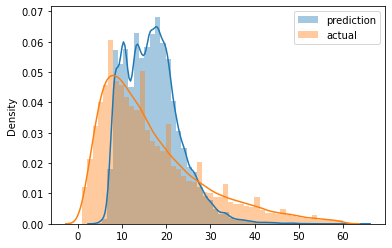

In [29]:
sns.distplot(y_pred, label = 'prediction')
sns.distplot(y_train, label = 'actual')
plt.legend()